# PGD ASR METRIC
## Author : Teofoli Matteo

In [3]:
# !pip install pandas numpy matplotlib <- If you do not have this installed on your computer, uncomment this line and execute it.

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



MEASURE_DIR = "tests/data/measures"

plt.style.use("default")


In [5]:


all_csv_files = glob.glob(os.path.join(MEASURE_DIR, "pgd_asr_*.csv"))
all_csv_files.sort(key=os.path.getmtime, reverse=True)
latest_csv_files = all_csv_files[:4]
latest_csv_files


['tests/data/measures/pgd_asr_densenet121_20251126_110259.csv',
 'tests/data/measures/pgd_asr_vgg16_20251126_105703.csv',
 'tests/data/measures/pgd_asr_mobilenet_v2_20251126_103821.csv',
 'tests/data/measures/pgd_asr_resnet18_20251126_103555.csv']

In [13]:
results = {}

for path in latest_csv_files:
    model_name = os.path.basename(path).split("_")[2]   
    df = pd.read_csv(path)
    results[model_name] = df

results


{'densenet121':      pred_before  pred_after  asr
 0              1          29  1.0
 1              1           1  0.0
 2              1           1  0.0
 3              1           1  0.0
 4              1           1  0.0
 ..           ...         ...  ...
 495            1           1  0.0
 496            1           1  0.0
 497          712         617  1.0
 498            1           1  0.0
 499            1           1  0.0
 
 [500 rows x 3 columns],
 'vgg16':      pred_before  pred_after  asr
 0            680         680  0.0
 1              1          29  1.0
 2              1           1  0.0
 3              1           1  0.0
 4            684         551  1.0
 ..           ...         ...  ...
 495          680         680  0.0
 496          901         969  1.0
 497          712         516  1.0
 498            5         551  1.0
 499          680         680  0.0
 
 [500 rows x 3 columns],
 'mobilenet':      pred_before  pred_after  asr
 0            149         149  0.0

In [14]:
model_asr = {
    model: df["asr"].mean()
    for model, df in results.items()
}

model_asr


{'densenet121': np.float64(0.16),
 'vgg16': np.float64(0.476),
 'mobilenet': np.float64(0.458),
 'resnet18': np.float64(0.43)}

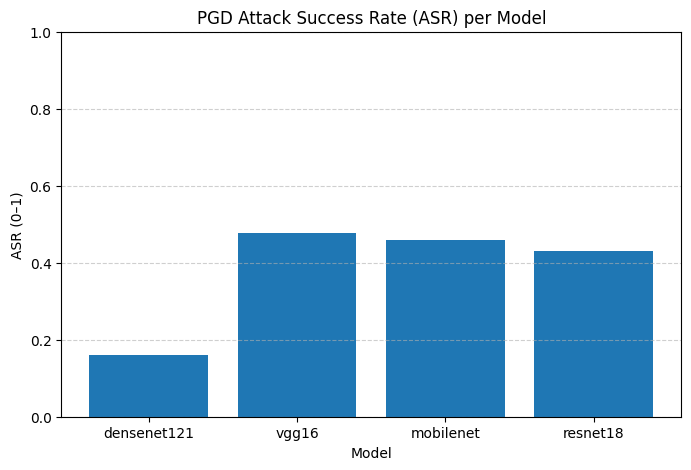

In [15]:
plt.figure(figsize=(8,5))
plt.bar(model_asr.keys(), model_asr.values())
plt.title("PGD Attack Success Rate (ASR) per Model")
plt.ylabel("ASR (0–1)")
plt.xlabel("Model")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


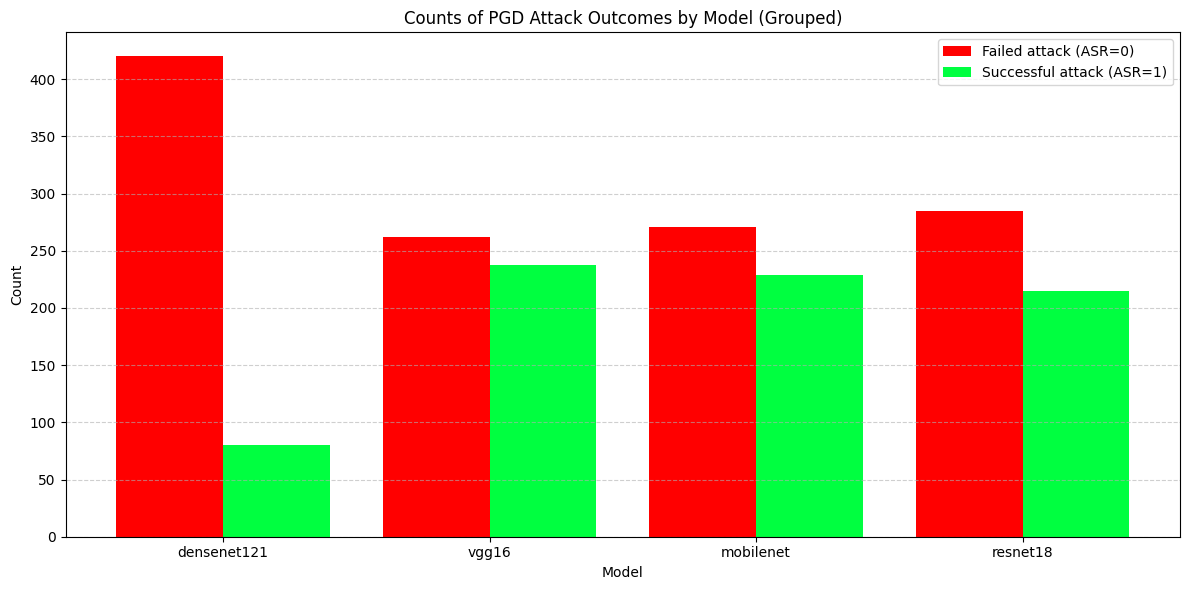

In [35]:
counts_data = {}
for model, df in results.items():
    outcome_counts = df["asr"].value_counts().reindex([0, 1], fill_value=0)
    counts_data[model] = [
        outcome_counts.get(0, 0),  
        outcome_counts.get(1, 0)   
    ]

counts_df = pd.DataFrame.from_dict(
    counts_data, 
    orient='index', 
    columns=["Failed attack", "Successful attack"]
)

models = counts_df.index

x = np.arange(len(models))  
width = 0.4

plt.figure(figsize=(12, 6))

plt.bar(
    x - width/2, 
    counts_df["Failed attack"], 
    width, 
    label='Failed attack (ASR=0)', 
    color="#ff0000" 
)

plt.bar(
    x + width/2, 
    counts_df["Successful attack"], 
    width, 
    label='Successful attack (ASR=1)', 
    color="#00ff40" 
)

plt.ylabel("Count")
plt.xlabel("Model")
plt.title("Counts of PGD Attack Outcomes by Model (Grouped)")
plt.xticks(x, models) 
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Most Robust Model (densenet121)**: __Densenet121__ shows the highest number of attack failures (highest red bar, approximately 420) and the lowest number of successes (lowest green bar, approximately 80). It is therefore the model that offers the best robustness against this PGD attack. 

**Least Robust Models (vgg16 and mobilenet)**: The __vgg16__ and mobilenet models show red and green bars of very similar height, indicating a high attack success rate (ASR) (around 45-50%). They are the most vulnerable to the PGD attack, as the attack succeeds almost as many times as it fails. 
__resnet18__: Resnet18 falls between the two extremes, with more failures than successes (red +-280, green +- 210$), making it less robust than densenet121 but more robust than vgg16/mobilenet. 

In summary, the PGD attack is least effective against the densenet121 model.

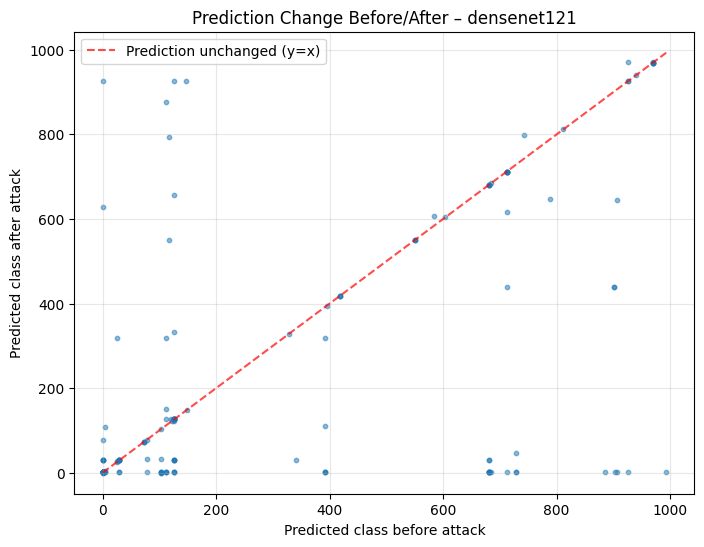

In [ ]:
model = list(results.keys())[0]  # -> if you want to change model just change the index 0 to another value
df = results[model]

max_class = max(df["pred_before"].max(), df["pred_after"].max())
plt.figure(figsize=(8,6))

plt.plot(
    [0, max_class],
    [0, max_class],
    '--',
    color='red',
    alpha=0.7,
    label='Prediction unchanged (y=x)'
)


plt.scatter(df["pred_before"], df["pred_after"], s=10, alpha=0.5)
plt.title(f"Prediction Change Before/After – {model}")
plt.xlabel("Predicted class before attack")
plt.ylabel("Predicted class after attack")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

This graph illustrates the change in class predicted by the Densenet121 model following the PGD attack.\
**Vulnerability (Scattered Points)**: There is a significant scattering of points away from the line $y=x$. This indicates that the attack has succeeded in changing the class prediction for a large number of instances (e.g., around the X=0 and X=700 axes). The model is therefore vulnerable to this attack.

**Partial Robustness (Points on the Line)**: A significant number of points remain close to the line $y=x$ (especially on the diagonal), which means that the attack failed for these examples, indicating partial robustness of the densenet121 model against this specific attack. 

**Target Concentration (X-axis)**: The majority of successful attacks seem to target samples whose initial class (before attack) is low (close to 0 on the X-axis) or medium (around 700).

In [37]:
for model, df in results.items():
    success_idx = df[df["asr"] == 1].index[:5]
    fail_idx = df[df["asr"] == 0].index[:5]
    
    print(f"\nModel: {model}")
    print(" Successful attack indexes:", list(success_idx))
    print(" Failed attack indexes:", list(fail_idx))



Model: densenet121
 Successful attack indexes: [0, 8, 13, 19, 20]
 Failed attack indexes: [1, 2, 3, 4, 5]

Model: vgg16
 Successful attack indexes: [1, 4, 6, 7, 8]
 Failed attack indexes: [0, 2, 3, 5, 9]

Model: mobilenet
 Successful attack indexes: [1, 5, 8, 12, 13]
 Failed attack indexes: [0, 2, 3, 4, 6]

Model: resnet18
 Successful attack indexes: [0, 1, 4, 5, 7]
 Failed attack indexes: [2, 3, 6, 8, 9]


A comparison of successful attack indices reveals that the models are not vulnerable to the same samples. For example, index 0 succeeds on ResNet18 but fails on MobileNet and VGG16. This diversity of weaknesses (or complementary robustness) is a key result. It demonstrates the potential of using an Ensemble of Models to combine the robustness of each architecture, providing a stronger defense against PGD attacks than any individual model.

In [38]:
summary = pd.DataFrame.from_dict(model_asr, orient="index", columns=["ASR"])
summary.sort_values("ASR", ascending=False)


,ASR
vgg16,0.476
mobilenet,0.458
resnet18,0.430
densenet121,0.160


# Conclusion

From the PGD-ASR analysis on 500 Tiny-ImageNet images:

- **Higher ASR = more vulnerable model** -> **vgg16**
- **Lower ASR = more robust model** -> **densenet121**

The visualizations show how prediction distributions shift under adversarial 
perturbations and allow a direct robustness comparison across architectures.


